# Predicting Diabetes Indicators


1. Abstract
2. About Dataset
3. Prerequisites
4. Data review
5. Feature extraction
6. Training model
7. Comparision Logistic Reggresion vs Decision Trees vs XGBoost
8. Summury

## Abstract

 The goals of this project is to predict posible to get diabetes based on annually, a health-related telephone survay by The Behavioral Risk Factor Surveillance System (BRFSS)

## About dataset


The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC. Each year, the survey collects responses from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services. It has been conducted every year since 1984. For this project, a csv of the dataset available on Kaggle for the year 2015 was used. This original dataset contains responses from 441,455 individuals and has 330 features.<br>
In this project we use third dataset wchich is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is not balanced.

## Prerequisites

In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold #for unbalanced data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from xgboost.sklearn import XGBClassifier
import time

## Data review


File name: diabetes_binary_health_indicators_BRFSS2015.csv<br>
Source: 

https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

Under this link we can find out whole describe of columns.

https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook

So, let's see basiscs of our data.

In [2]:
data = pd.read_csv(r'C:\Users\pdrynkowski\ds\diabetes_binary_health_indicators_BRFSS2015.csv')

Primary information about dataset

In [3]:
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

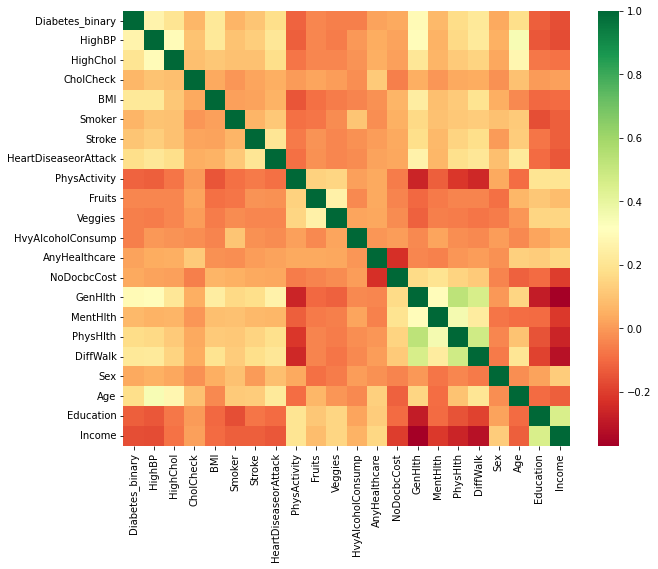

In [5]:
#Heat map
plt.figure(figsize=(10,8))
p = sns.heatmap(data.corr(), annot=False,cmap ="RdYlGn", robust=False)

In [6]:
data.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

 As we can see, all of the data is complete, no missing data in any of column, all of them are float type.

# Feature Extraction

Column Diabetes_binary is our target to predict.<BR>
Columns HighBP, HighChol, CholCheck are binary, so we can easly transform the data to one hot coding.<br>
BMI data has vary diffrent values, so we can try to transform it to some range, But firstly we looks at data distribution using BoxPlot by Seborn module.

<AxesSubplot:>

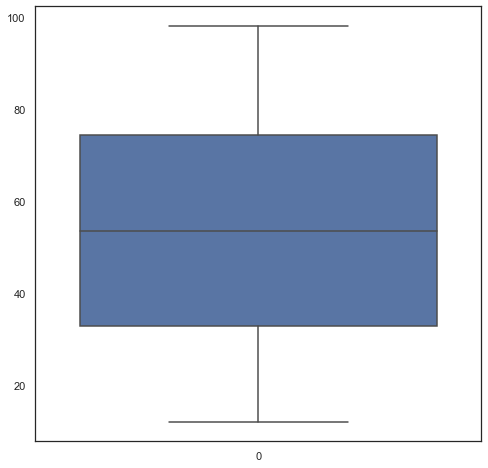

In [7]:
sns.set(rc={'figure.figsize':(8,8)})
sns.set_style("white")
sns.boxplot(data=data.BMI.value_counts().index)

As we can see, quartiles of data is balanced, but both of whiskeres are big, I think it can bad impact to predict, because some level of obesity (e.g. 35 +) is enough to be unheathy.<BR/>
However,  we dont trunc any data, instead,  divide the data to five bins, to transpose data as categories, starts from 12 beacouse this is minimum value.

In [8]:
#start from copy original data
diabetes = data;

In [9]:
bins = [12,20,30,40,60,100]
categories=["Normal","Over_weight","Obesity","Huge_obesity","Max_obesity"]
diabetes.insert(5,"BMI_Range", pd.cut(diabetes.BMI,bins=bins,labels=categories,right=False))

 

In [10]:
diabetes = diabetes.drop(["BMI"], axis=1)

 Let's see how the data of BMI marker looks now

In [11]:
diabetes.BMI_Range.value_counts()


Over_weight     158734
Obesity          74114
Huge_obesity     12869
Normal            7095
Max_obesity        868
Name: BMI_Range, dtype: int64

Gosh, Over weight bin is the biggest, but we should remember the data is from investigation of 2015 year :)

Let's chose columns which seems to be binary data, but we need check them. We use simple histogram to do that.

In [169]:
df_hist = diabetes[['HighBP','HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                 'PhysActivity', 'Fruits', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']]


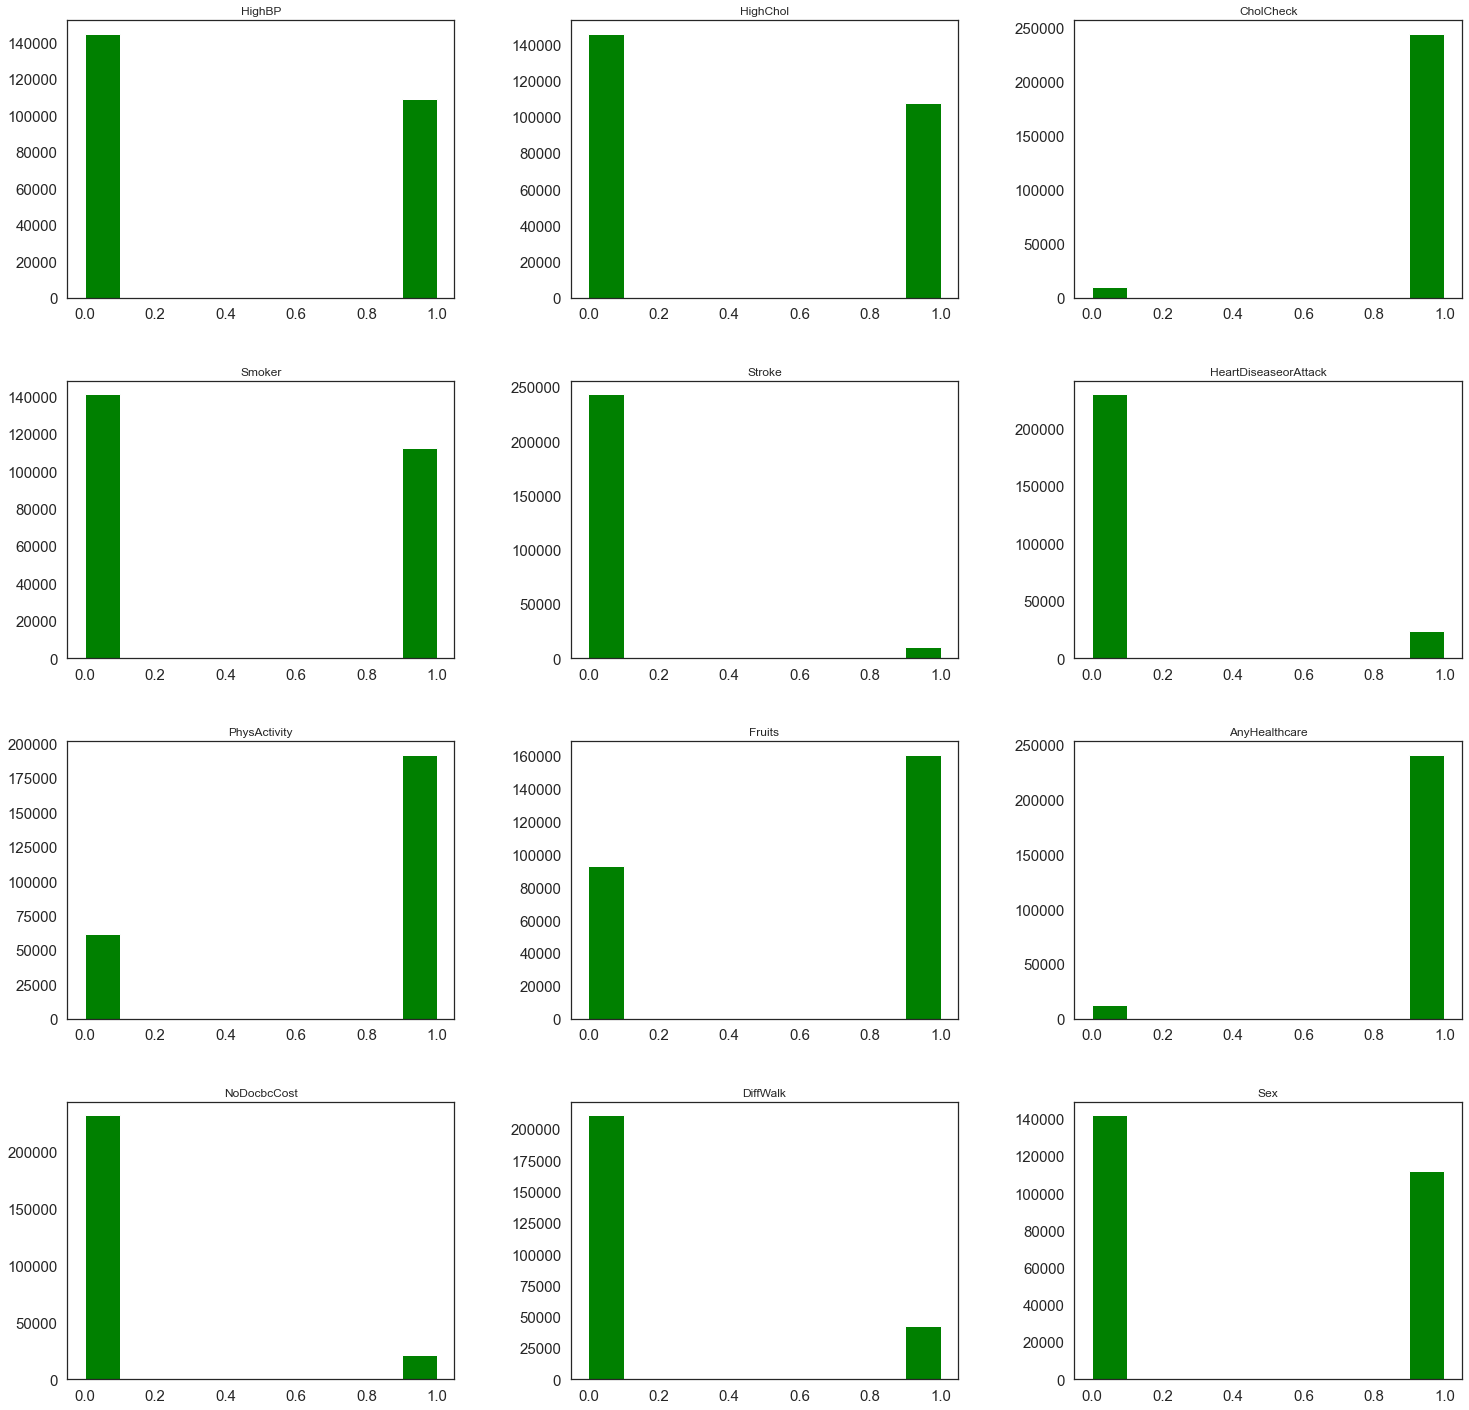

In [215]:
hist = df_hist.hist(color = 'green',bins=10, grid=False, figsize = (25,25), ylabelsize=15, xlabelsize=15, range=[0,1]) 

Ok, it seems to no NaN values,let's carry on review od our data.

In [22]:
diabetes.GenHlth.value_counts()#categories, no transform

2.0    89084
3.0    75646
1.0    45299
4.0    31570
5.0    12081
Name: GenHlth, dtype: int64

In [23]:
diabetes.MentHlth.value_counts()#lots of diffrent values, let's see more

0.0     175680
2.0      13054
30.0     12088
5.0       9030
1.0       8538
3.0       7381
10.0      6373
15.0      5505
4.0       3789
20.0      3364
7.0       3100
25.0      1188
14.0      1167
6.0        988
8.0        639
12.0       398
28.0       327
21.0       227
29.0       158
18.0        97
9.0         91
16.0        88
27.0        79
22.0        63
17.0        54
26.0        45
11.0        41
13.0        41
23.0        38
24.0        33
19.0        16
Name: MentHlth, dtype: int64

Following the description of MentHlth column we know, it is count of days people feeled stress, it can be huge impact of any disease (imho).<BR>
We need to divide this data, let's see describe column and decide what range apply.

In [24]:
diabetes.MentHlth.describe()

count    253680.000000
mean          3.184772
std           7.412847
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          30.000000
Name: MentHlth, dtype: float64

Two of first quartiles so also median values equal zero, nice :)<BR>
Let's try to divide of 3 bins

In [25]:
bins_mh = [0,7,14,21,31]
categories_mh=["No_stress","Middle_stress","Stressful", "Extreme_stress"]
diabetes.insert(15,"Stress_level", pd.cut(diabetes.MentHlth,bins=bins_mh,labels=categories_mh,right=False))
diabetes = diabetes.drop(["MentHlth"], axis=1)

Bins looks this

In [26]:
diabetes.Stress_level.value_counts()

No_stress         218460
Extreme_stress     14246
Middle_stress      10683
Stressful          10291
Name: Stress_level, dtype: int64

Carry on

In [29]:
diabetes.Age.value_counts()

9.0     33244
10.0    32194
8.0     30832
7.0     26314
11.0    23533
6.0     19819
13.0    17363
5.0     16157
12.0    15980
4.0     13823
3.0     11123
2.0      7598
1.0      5700
Name: Age, dtype: int64

Following the manual for diabetes data set: 1 is 18-24 all the way up to 13, menas 80 and older. 5 year increments

In [30]:
diabetes.Education.value_counts()#categories, no transform

6.0    107325
5.0     69910
4.0     62750
3.0      9478
2.0      4043
1.0       174
Name: Education, dtype: int64

In [31]:
diabetes.Income.value_counts()# 1 being less than $10,000 all the way up to 8 being $75,000 or more

8.0    90385
7.0    43219
6.0    36470
5.0    25883
4.0    20135
3.0    15994
2.0    11783
1.0     9811
Name: Income, dtype: int64

After review data, it's time for prepare data to predict

In [35]:
X = diabetes.drop("Diabetes_binary", axis=1)#coeficient
y = diabetes.Diabetes_binary#target

Firstly we have to divide the data on training and testing section, we need to do now, becouse the test data can't impact of train data and whole model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,
random_state=5)

OneHotcoding, drop first to avoid linear relationship(less important to Random Forest, but importand using Logistic Regression ), in X_test dataset we use reindex() function to avoid missed column for categorial columns when new data comes.

In [37]:
X_train = pd.get_dummies(X_train, drop_first=True)

In [38]:
X_test = pd.get_dummies(X_test.reindex(columns = X_train.columns, fill_value=0), drop_first=True)

[Text(0.5, 1.0, 'Bar plot of target column')]

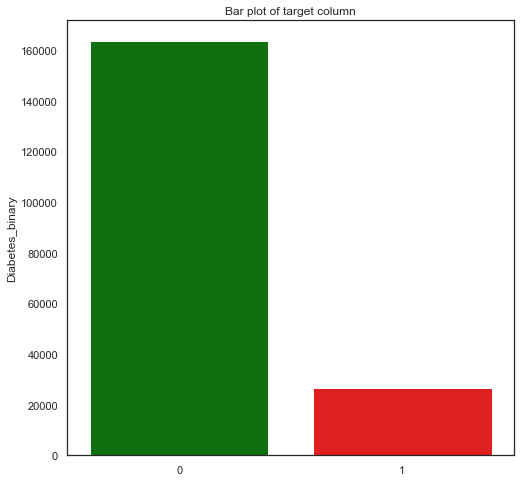

In [39]:
sns.barplot(x=[0,1], y=y_train.value_counts(), palette=["green", "red"]).set(title="Bar plot of target column")

The data is high imbalanced, we can use SMOTE alghoritm to create artifitial data<BR>
This technique creates new instances of minority group data by copying existing data and making minor changes to it.<BR>
 

In [40]:
oversample = SMOTE(sampling_strategy='auto', k_neighbors=6, random_state=42)

In [41]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

<AxesSubplot:ylabel='Diabetes_binary'>

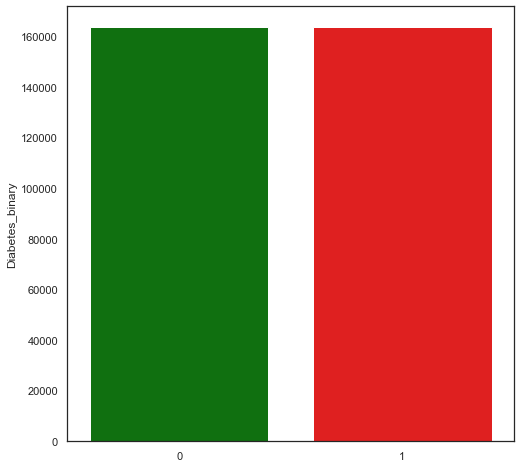

In [42]:
sns.barplot(x=[0,1], y=y_train.value_counts(), palette=["green", "red"])

Now we have equal data of ones and zeros, lets make pipeline and find the best model.
Whereas original data was unbalanced and we  Using F1 score as a metric, we are sure that if the F1 score is high, both precision and recall of the classifier indicate good results.

## Comparision Logistic Reggresion vs Decision Trees vs XGBoost


### Compare score for three classifier using default hyperparameters

In [115]:
models_df = pd.DataFrame()

models = [
    
    DecisionTreeClassifier(),
    LogisticRegression(),
    XGBClassifier()   
]
scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]

pipe = Pipeline(steps = [
    ('scaler', None), 
    ('classifier', None)])

for model in models:
    for scaler in scalers:
        pipe_params = {'scaler' : scaler,
                       'classifier' : model}

        pipe.set_params(**pipe_params)

        start_time = time.time()
        pipe.fit(X_train, y_train)   
        end_time = time.time()
        
        score = pipe.score(X_test, y_test)
        
        param_dict = {
                            'model': model.__class__.__name__,
                            'scaler': scaler.__class__.__name__,
                            'score': score,
                            'time_elapsed': end_time - start_time
                }
 
        models_df = pd.concat([pd.DataFrame(param_dict, index=[0]), models_df])  
 

C:\Users\pdrynkowski\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Let's see what algorythm had best score

In [114]:
models_df.sort_values(['score','time_elapsed'], ascending=False, ignore_index=True)

,model,scaler,score,time_elapsed
0,XGBClassifier,MinMaxScaler,0.840350,19.089963
1,XGBClassifier,StandardScaler,0.840350,16.189717
2,DecisionTreeClassifier,MinMaxScaler,0.736645,2.448455
3,DecisionTreeClassifier,StandardScaler,0.734153,2.465444
4,XGBClassifier,Normalizer,0.732025,38.271681
5,DecisionTreeClassifier,Normalizer,0.720467,7.425224
6,LogisticRegression,MinMaxScaler,0.477405,3.082758
7,LogisticRegression,StandardScaler,0.477010,0.667172
8,LogisticRegression,Normalizer,0.412362,3.614337


Ok, so, XGBoost using Standard Scaler is best combination, let's try to use it to predict and will find best hyperparameters.
We use 2 grids combination with four hyper parameters as well.(every dictionary make one gird)

### XGBoost Classifier

In [190]:
kfold = StratifiedKFold(5, shuffle=True, random_state=123)#we make 5 "bin" with random choose
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
    ])
 

params = [{'model__gamma': [0.5,1],
           'model__max_depth': [4,6,8]},
           {'model__min_child_weight': [5, 10, 30],
           'model__learning_rate': [0.1, 3]}]

optimizer = GridSearchCV(pipeline,
                        params,
                        scoring="accuracy",
                        cv=kfold,
                        n_jobs=-1)

optimizer.fit(X_train, y_train)
y_pred = optimizer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8227057710501419

Let's see what hyperparameters was best for our model

In [200]:
summury_hyperp = pd.DataFrame(optimizer.cv_results_['params'])
summury_hyperp.insert(4, 'score', optimizer.cv_results_['mean_test_score'])
summury_hyperp.sort_values(['score'], ascending=False, ignore_index=True)

,model__gamma,model__max_depth,model__learning_rate,model__min_child_weight,score
0,1.0,6.0,NaN,NaN,0.913360
1,0.5,6.0,NaN,NaN,0.913106
2,0.5,8.0,NaN,NaN,0.912810
3,1.0,8.0,NaN,NaN,0.912797
4,1.0,4.0,NaN,NaN,0.911804
5,0.5,4.0,NaN,NaN,0.911649
6,NaN,NaN,0.1,10.0,0.904377
7,NaN,NaN,0.1,30.0,0.904270
8,NaN,NaN,0.1,5.0,0.903924
9,NaN,NaN,3.0,30.0,0.625405


## Summury

Finally, we obtain 0.82 with accuracy_score metrics which is a function that is used to calculate the accuracy of a classification model.<br>Hyperparameters had not big impact to best score, but quite big impact to worst score :) <br>
0.82 is a quite nice value if we talko about passing final project , but if we talk about medical purpose, we should find better model :)